In [18]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
#PATH = '/content/drive/My Drive/PPM_Stability/'
#PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/Mythreyi/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
PATH = "C:/Users/n9455647/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

In [19]:
#!pip install --upgrade numpy

In [20]:
from DatasetManager import DatasetManager

import pandas as pd
import numpy as np

import os
import sys
from sys import argv
import pickle
import random
import joblib

from sklearn.metrics import accuracy_score
#import tensorflow as tf
#tf.keras.compat.disable_v2_backend()
from tensorflow.keras.backend import print_tensor
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing import sequence
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Embedding, Flatten, Input
from keras.layers import LSTM
from keras.optimizers import Nadam, RMSprop
from tensorflow.keras.utils import plot_model
from keras.layers.normalization import BatchNormalization

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statistics
import math

import warnings
warnings.filterwarnings('ignore')

In [17]:
datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index", "lstm_single_3d"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}


for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])
    print(dataset_manager.get_class_ratio(dataset_manager.read_dataset()))    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/" %(data, method))
        
        if "single" in method:
            num_buckets = 1
        else:
            num_buckets = len([name for name in os.listdir(os.path.join(folder_loc,'models/'))])
            
        for bucket in range(num_buckets):
            if "lstm" in method:
                bucketID = "all"
            else:
                bucketID = bucket+1
            print ('Bucket', bucketID)
            
            X_train_path = os.path.join(folder_loc, "train_data/bucket_%s_prefixes.pickle" % (bucketID))
            with open (X_train_path, 'rb') as f:
                dt_train_bucket = pickle.load(f)

            X_test_path = os.path.join(folder_loc, "test_data/bucket_%s_prefixes.pickle" % (bucketID))
            with open (X_test_path, 'rb') as f:
                dt_test_bucket = pickle.load(f)
            

            if "lstm" not in method: 
                y_train = dataset_manager.get_label_numeric(dt_train_bucket)
                y_test = dataset_manager.get_label_numeric(dt_test_bucket)
            
                train_pos_cases = len([i for i in y_train if i == 1])
                train_neg_cases = len([i for i in y_train if i == 0])
                train_pos_ratio = train_pos_cases/(train_pos_cases + train_neg_cases)
                print("\tPositives in training set:", train_pos_ratio)

                test_pos_cases = len([i for i in y_test if i == 1])
                test_neg_cases = len([i for i in y_test if i == 0])
                test_pos_ratio = test_pos_cases/(test_pos_cases + test_neg_cases)
                print("\tPositives in testing set:", test_pos_ratio)
                
                feat_comb_path = os.path.join(folder_loc, "bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (bucketID))
                with open (feat_comb_path, 'rb') as f:
                    feature_combiner = joblib.load(f)
                
                train_x = feature_combiner.transform(dt_train_bucket)
                test_x = feature_combiner.transform(dt_test_bucket)
                vector_length = test_x[0].shape
                
                print("Training instances:", len(y_train))
                print("Testing instances:", len(y_test))
                print("Feature Vector Length:", vector_length)
                
            else:
                y_train_path = os.path.join(folder_loc, "train_data/bucket_%s_labels.pickle" % (bucketID))
                with open (y_train_path, 'rb') as f:
                    train_y = pickle.load(f)

                y_test_path = os.path.join(folder_loc, "test_data/bucket_%s_labels.pickle" % (bucketID))
                with open (y_test_path, 'rb') as f:
                    test_y = pickle.load(f)
                
                y_train = [int(np.where(i==1)[0]) for i in train_y]
                y_test = test_y
               
                train_pos_cases = len([i for i in y_train if i == 1])
                train_neg_cases = len([i for i in y_train if i == 0])
                train_pos_ratio = train_pos_cases/(train_pos_cases + train_neg_cases)
                print("\tPositives in training set:", train_pos_ratio)

                test_pos_cases = len([i for i in y_test if i == 1])
                test_neg_cases = len([i for i in y_test if i == 0])
                test_pos_ratio = test_pos_cases/(test_pos_cases + test_neg_cases)
                print("\tPositives in testing set:", test_pos_ratio)
                
                vector_length = dt_test_bucket[0].shape
                
                print("Training instances:", len(y_train))
                print("Testing instances:", len(y_test))
                print("Feature Vector Length:", vector_length)

production
0.549618320610687
xgboost_single_agg
Bucket 1
	Positives in training set: 0.5879360465116279
	Positives in testing set: 0.4598155467720685
Training instances: 1376
Testing instances: 759
Feature Vector Length: (162,)
xgboost_prefix_agg
Bucket 1
	Positives in training set: 0.5984848484848485
	Positives in testing set: 0.4318181818181818
Training instances: 132
Testing instances: 88
Feature Vector Length: (146,)
Bucket 2
	Positives in training set: 0.6031746031746031
	Positives in testing set: 0.4523809523809524
Training instances: 126
Testing instances: 84
Feature Vector Length: (153,)
Bucket 3
	Positives in training set: 0.6083333333333333
	Positives in testing set: 0.46153846153846156
Training instances: 120
Testing instances: 78
Feature Vector Length: (150,)
Bucket 4
	Positives in training set: 0.5909090909090909
	Positives in testing set: 0.4411764705882353
Training instances: 110
Testing instances: 68
Feature Vector Length: (150,)
Bucket 5
	Positives in training set: 0.5

	Positives in training set: 0.15952702001867025
	Positives in testing set: 0.10870437224227839
Training instances: 9641
Testing instances: 2493
Feature Vector Length: (274,)
xgboost_prefix_agg
Bucket 1
	Positives in training set: 0.1488
	Positives in testing set: 0.11464968152866242
Training instances: 625
Testing instances: 157
Feature Vector Length: (192,)
Bucket 2
	Positives in training set: 0.1488
	Positives in testing set: 0.11464968152866242
Training instances: 625
Testing instances: 157
Feature Vector Length: (191,)
Bucket 3
	Positives in training set: 0.1488
	Positives in testing set: 0.11464968152866242
Training instances: 625
Testing instances: 157
Feature Vector Length: (197,)
Bucket 4
	Positives in training set: 0.1488
	Positives in testing set: 0.11464968152866242
Training instances: 625
Testing instances: 157
Feature Vector Length: (190,)
Bucket 5
	Positives in training set: 0.1488
	Positives in testing set: 0.11464968152866242
Training instances: 625
Testing instances: 1

Training instances: 180
Testing instances: 49
Feature Vector Length: (474,)
Bucket 18
	Positives in training set: 0.16447368421052633
	Positives in testing set: 0.05263157894736842
Training instances: 152
Testing instances: 38
Feature Vector Length: (476,)
Bucket 19
	Positives in training set: 0.16541353383458646
	Positives in testing set: 0.05555555555555555
Training instances: 133
Testing instances: 36
Feature Vector Length: (471,)
Bucket 20
	Positives in training set: 0.18181818181818182
	Positives in testing set: 0.0625
Training instances: 121
Testing instances: 32
Feature Vector Length: (506,)
Bucket 21
	Positives in training set: 0.18181818181818182
	Positives in testing set: 0.07142857142857142
Training instances: 99
Testing instances: 28
Feature Vector Length: (505,)
Bucket 22
	Positives in training set: 0.16470588235294117
	Positives in testing set: 0.08333333333333333
Training instances: 85
Testing instances: 24
Feature Vector Length: (484,)
Bucket 23
	Positives in training s

Training instances: 1995
Testing instances: 547
Feature Vector Length: (134,)
Bucket 33
	Positives in training set: 0.5782422293676313
	Positives in testing set: 0.6424361493123772
Training instances: 1866
Testing instances: 509
Feature Vector Length: (134,)
Bucket 34
	Positives in training set: 0.5890022675736961
	Positives in testing set: 0.6521739130434783
Training instances: 1764
Testing instances: 483
Feature Vector Length: (134,)
Bucket 35
	Positives in training set: 0.5908267954133977
	Positives in testing set: 0.6592920353982301
Training instances: 1657
Testing instances: 452
Feature Vector Length: (134,)
Bucket 36
	Positives in training set: 0.5957988542329726
	Positives in testing set: 0.6839622641509434
Training instances: 1571
Testing instances: 424
Feature Vector Length: (134,)
Bucket 37
	Positives in training set: 0.596244131455399
	Positives in testing set: 0.6842105263157895
Training instances: 1491
Testing instances: 399
Feature Vector Length: (134,)
Bucket 38
	Positiv

Training instances: 1418
Testing instances: 382
Feature Vector Length: (2681,)
Bucket 39
	Positives in training set: 0.6067924528301887
	Positives in testing set: 0.6940509915014165
Training instances: 1325
Testing instances: 353
Feature Vector Length: (2752,)
Bucket 40
	Positives in training set: 0.6185155626496409
	Positives in testing set: 0.7091988130563798
Training instances: 1253
Testing instances: 337
Feature Vector Length: (2829,)
lstm_single_3d
Bucket all
	Positives in training set: 0.49785241817713255
	Positives in testing set: 0.5539380487645658
Training instances: 93128
Testing instances: 30637
Feature Vector Length: (40, 102)


production
xgboost_single_agg
Bucket 1


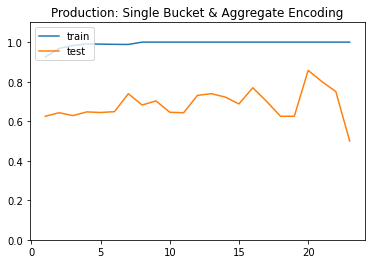

	Training accuracy: 0.9854651162790697
		Training accuracy - Positives: 0.9949811794228356
		Training accuracy - Negatives: 0.9723661485319517
	Testing accuracy: 0.6653491436100132
		Testing accuracy - Positives: 0.6107226107226107
		Testing accuracy - Negatives: 0.7363636363636363
xgboost_prefix_agg
Bucket 1
Bucket 2
Bucket 3
Bucket 4
Bucket 5
Bucket 6
Bucket 7
Bucket 8
Bucket 9
Bucket 10
Bucket 11
Bucket 12
Bucket 13
Bucket 14
Bucket 15
Bucket 16
Bucket 17
Bucket 18
Bucket 19
Bucket 20
Bucket 21
Bucket 22
Bucket 23


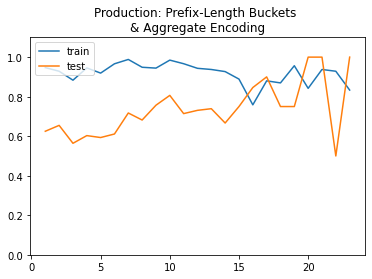

	Training accuracy: 0.9324127906976745
		Training accuracy - Positives: 1.0
		Training accuracy - Negatives: 0.8590909090909091
	Testing accuracy: 0.6706192358366272
		Testing accuracy - Positives: 0.6306068601583114
		Testing accuracy - Negatives: 0.7105263157894737
xgboost_prefix_index
Bucket 1
Bucket 2
Bucket 3
Bucket 4
Bucket 5
Bucket 6
Bucket 7
Bucket 8
Bucket 9
Bucket 10
Bucket 11
Bucket 12
Bucket 13
Bucket 14
Bucket 15
Bucket 16
Bucket 17
Bucket 18
Bucket 19
Bucket 20
Bucket 21
Bucket 22
Bucket 23


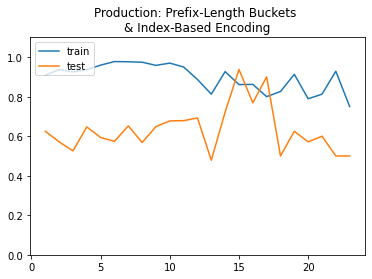

	Training accuracy: 0.9251453488372093
		Training accuracy - Positives: 0.998587570621469
		Training accuracy - Negatives: 0.8473053892215568
	Testing accuracy: 0.6179183135704874
		Testing accuracy - Positives: 0.594855305466238
		Testing accuracy - Negatives: 0.6339285714285714
sepsis_cases
xgboost_single_agg
Bucket 1


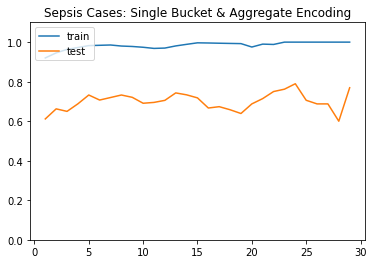

	Training accuracy: 0.9742765273311897
		Training accuracy - Positives: 0.8611422172452408
		Training accuracy - Negatives: 1.0
	Testing accuracy: 0.6967509025270758
		Testing accuracy - Positives: 0.08967851099830795
		Testing accuracy - Negatives: 0.8853838065194533
xgboost_prefix_agg
Bucket 1
Bucket 2
Bucket 3
Bucket 4
Bucket 5
Bucket 6
Bucket 7
Bucket 8
Bucket 9
Bucket 10
Bucket 11
Bucket 12
Bucket 13
Bucket 14
Bucket 15
Bucket 16
Bucket 17
Bucket 18
Bucket 19
Bucket 20
Bucket 21
Bucket 22
Bucket 23
Bucket 24
Bucket 25
Bucket 26
Bucket 27
Bucket 28
Bucket 29


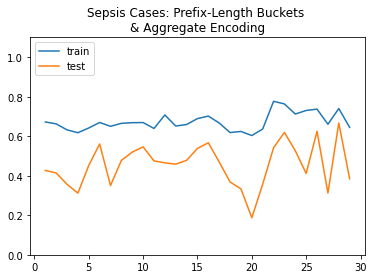

	Training accuracy: 0.6607198423400062
		Training accuracy - Positives: 0.31981700977334165
		Training accuracy - Negatives: 1.0
	Testing accuracy: 0.45046129161652626
		Testing accuracy - Positives: 0.09144981412639405
		Testing accuracy - Negatives: 0.8710801393728222
xgboost_prefix_index
Bucket 1
Bucket 2
Bucket 3
Bucket 4
Bucket 5
Bucket 6
Bucket 7
Bucket 8
Bucket 9
Bucket 10
Bucket 11
Bucket 12
Bucket 13
Bucket 14
Bucket 15
Bucket 16
Bucket 17
Bucket 18
Bucket 19
Bucket 20
Bucket 21
Bucket 22
Bucket 23
Bucket 24
Bucket 25
Bucket 26
Bucket 27
Bucket 28
Bucket 29


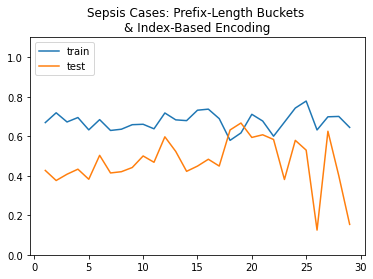

	Training accuracy: 0.6712996577118556
		Training accuracy - Positives: 0.3267473974930954
		Training accuracy - Negatives: 1.0
	Testing accuracy: 0.45808263136782995
		Testing accuracy - Positives: 0.09337349397590361
		Testing accuracy - Negatives: 0.8738197424892704
bpic2012
xgboost_single_agg
Bucket 1


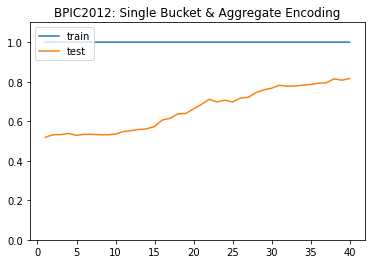

	Training accuracy: 0.9999915229093375
		Training accuracy - Positives: 0.9999830821025563
		Training accuracy - Negatives: 1.0
	Testing accuracy: 0.6342004765479649
		Testing accuracy - Positives: 0.6842946668371914
		Testing accuracy - Negatives: 0.5819721314754317
xgboost_prefix_agg
Bucket 1
Bucket 2
Bucket 3
Bucket 4
Bucket 5
Bucket 6
Bucket 7
Bucket 8
Bucket 9
Bucket 10
Bucket 11
Bucket 12
Bucket 13
Bucket 14
Bucket 15
Bucket 16
Bucket 17
Bucket 18
Bucket 19
Bucket 20
Bucket 21
Bucket 22
Bucket 23
Bucket 24
Bucket 25
Bucket 26
Bucket 27
Bucket 28
Bucket 29
Bucket 30
Bucket 31
Bucket 32
Bucket 33
Bucket 34
Bucket 35
Bucket 36
Bucket 37
Bucket 38
Bucket 39
Bucket 40


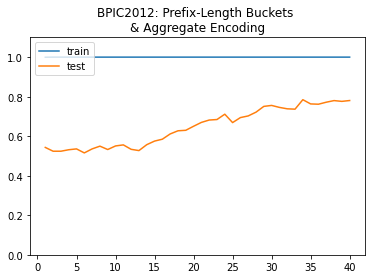

	Training accuracy: 0.999983045818675
		Training accuracy - Positives: 1.0
		Training accuracy - Negatives: 0.9999660204896448
	Testing accuracy: 0.6237882299180729
		Testing accuracy - Positives: 0.6672194582642343
		Testing accuracy - Negatives: 0.5745332961827807
xgboost_prefix_index
Bucket 1
Bucket 2
Bucket 3
Bucket 4
Bucket 5
Bucket 6
Bucket 7
Bucket 8
Bucket 9
Bucket 10
Bucket 11
Bucket 12
Bucket 13
Bucket 14
Bucket 15
Bucket 16
Bucket 17
Bucket 18
Bucket 19
Bucket 20
Bucket 21
Bucket 22
Bucket 23
Bucket 24
Bucket 25
Bucket 26
Bucket 27
Bucket 28
Bucket 29
Bucket 30
Bucket 31
Bucket 32
Bucket 33
Bucket 34
Bucket 35
Bucket 36
Bucket 37
Bucket 38
Bucket 39
Bucket 40


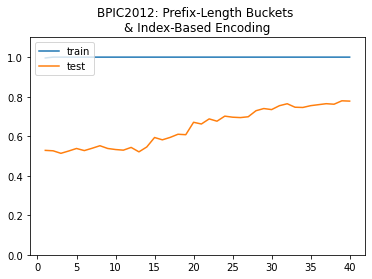

	Training accuracy: 0.9998643665494003
		Training accuracy - Positives: 0.9998139188686267
		Training accuracy - Negatives: 0.9999150396764711
	Testing accuracy: 0.620556843032934
		Testing accuracy - Positives: 0.6714340687532068
		Testing accuracy - Negatives: 0.5678298438019276


In [5]:
datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}
titles = {"production": "Production: ", "sepsis_cases": "Sepsis Cases: ", "bpic2012": "BPIC2012: ",
         "xgboost_single_agg": "Single Bucket & Aggregate Encoding", "xgboost_prefix_agg": "Prefix-Length Buckets \n& Aggregate Encoding",
         "xgboost_prefix_index": "Prefix-Length Buckets \n& Index-Based Encoding"}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/" %(data, method))
        
        if "single" in method:
            num_buckets = 1
        else:
            num_buckets = len([name for name in os.listdir(os.path.join(folder_loc,'models/'))])
            
        train_lengths = []
        train_predictions = []
        train_y_all = []
        
        test_lengths = []
        test_predictions = []
        test_y_all = []
            
        for bucket in range(num_buckets):
            if "lstm" in method:
                bucketID = "all"
            else:
                bucketID = bucket+1
            print ('Bucket', bucketID)
            
            X_train_path = os.path.join(folder_loc, "train_data/bucket_%s_prefixes.pickle" % (bucketID))
            with open (X_train_path, 'rb') as f:
                dt_train_bucket = pickle.load(f)

            X_test_path = os.path.join(folder_loc, "test_data/bucket_%s_prefixes.pickle" % (bucketID))
            with open (X_test_path, 'rb') as f:
                dt_test_bucket = pickle.load(f)
            

            if "lstm" not in method: 
                y_train = dataset_manager.get_label_numeric(dt_train_bucket)
                y_test = dataset_manager.get_label_numeric(dt_test_bucket)
            
                train_pos_cases = len([i for i in y_train if i == 1])
                train_neg_cases = len([i for i in y_train if i == 0])
                train_pos_ratio = train_pos_cases/(train_pos_cases + train_neg_cases)
                #print("\tPositives in training set:", train_pos_ratio)

                test_pos_cases = len([i for i in y_test if i == 1])
                test_neg_cases = len([i for i in y_test if i == 0])
                test_pos_ratio = test_pos_cases/(test_pos_cases + test_neg_cases)
                #print("\tPositives in testing set:", test_pos_ratio)
                
                pipeline_path = os.path.join(folder_loc, "pipelines/pipeline_bucket_%s.joblib" % (bucketID))
                with open (pipeline_path, 'rb') as f:
                    pipeline = joblib.load(f)
                
                prefix_lengths = dataset_manager.get_prefix_lengths(dt_train_bucket)             
                train_lengths.extend(prefix_lengths.values)
                
                prefix_lengths = dataset_manager.get_prefix_lengths(dt_test_bucket)             
                test_lengths.extend(prefix_lengths.values)
                
                train_preds = pipeline.predict(dt_train_bucket)
                train_predictions.extend(train_preds)
                
                test_preds = pipeline.predict(dt_test_bucket)
                test_predictions.extend(test_preds)
                
                train_y_all.extend(y_train)
                test_y_all.extend(y_test)
                
#             else:
#                 y_train_path = os.path.join(folder_loc, "train_data/bucket_%s_labels.pickle" % (bucketID))
#                 with open (y_train_path, 'rb') as f:
#                     train_y = pickle.load(f)

#                 y_test_path = os.path.join(folder_loc, "test_data/bucket_%s_labels.pickle" % (bucketID))
#                 with open (y_test_path, 'rb') as f:
#                     test_y = pickle.load(f)
                
#                 y_train = [int(np.where(i==1)[0]) for i in train_y]
#                 y_test = test_y
                
#                 cls_path = os.path.join(folder_loc, "cls/pred_cls.h5")
#                 cls = load_model(cls_path)
                
#                 preds = cls.predict(dt_train_bucket)
#                 train_preds = [np.argmax(i, axis = -1) for i in preds]
                
#                 preds = cls.predict(dt_test_bucket)
#                 test_preds = [np.argmax(i, axis = -1) for i in preds]
            
        lens = list(set(train_lengths))
        train_accs = []
        test_accs = []
        for i in lens:
            idxs = [n for n in range(len(train_lengths)) if train_lengths[n] == i]
            preds = [train_predictions[n] for n in idxs]
            actual = [train_y_all[n] for n in idxs]
            accuracy = accuracy_score(actual, preds)
            train_accs.append(accuracy)
            
            idxs = [n for n in range(len(test_lengths)) if test_lengths[n] == i]
            preds = [test_predictions[n] for n in idxs]
            actual = [test_y_all[n] for n in idxs]
            accuracy = accuracy_score(actual, preds)
            test_accs.append(accuracy)


        plt.plot(lens, train_accs, label = 'train')
        plt.plot(lens, test_accs, label = 'test')
        plt.legend(loc = "upper left")
        plt.ylim(0,1.1)
        plt.title(titles[data]+titles[method])
        plt.show()
        
        train_acc = accuracy_score(train_y_all, train_predictions)
        print("\tTraining accuracy:", train_acc)
        
        train_pos_idx = [i for i in range(len(train_predictions)) if train_predictions[i] == 1]
        actual = [train_y_all[i] for i in train_pos_idx]
        preds = [train_predictions[i] for i in train_pos_idx]
        train_pos_acc = accuracy_score(actual, preds)
        print("\t\tTraining accuracy - Positives:", train_pos_acc)
        
        train_neg_idx = [i for i in range(len(train_predictions)) if train_predictions[i] == 0]
        actual = [train_y_all[i] for i in train_neg_idx]
        preds = [train_predictions[i] for i in train_neg_idx]
        train_neg_acc = accuracy_score(actual, preds)
        print("\t\tTraining accuracy - Negatives:", train_neg_acc)
        
        test_acc = accuracy_score(test_y_all, test_predictions)
        print("\tTesting accuracy:", test_acc)
        
        test_pos_idx = [i for i in range(len(test_predictions)) if test_predictions[i] == 1]
        actual = [test_y_all[i] for i in test_pos_idx]
        preds = [test_predictions[i] for i in test_pos_idx]
        test_pos_acc = accuracy_score(actual, preds)
        print("\t\tTesting accuracy - Positives:", test_pos_acc)
        
        test_neg_idx = [i for i in range(len(test_predictions)) if test_predictions[i] == 0]
        actual = [test_y_all[i] for i in test_neg_idx]
        preds = [test_predictions[i] for i in test_neg_idx]
        test_neg_acc = accuracy_score(actual, preds)
        print("\t\tTesting accuracy - Negatives:", test_neg_acc)
            
        #break
                

bpic2012
xgboost_single_agg
xgboost_prefix_agg
xgboost_prefix_index


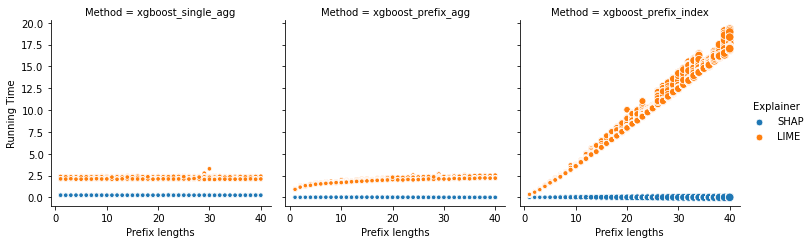

In [6]:
datasets = ["bpic2012"]
#datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}
data_names = {"production":"Production", "sepsis_cases":"Sepsis Cases", "bpic2012":"BPIC2012"}
method_names = {"xgboost_single_agg": "Single Bucket with Aggregate Encoding", 
               "xgboost_prefix_agg": "Prefix-Length Buckets with Aggregate Encoding", 
               "xgboost_prefix_index": "Prefix-Length Buckets with Index-Based Encoding"}

all_pref_lens = []
all_feat_lens = []
all_explainers = []
all_times = []
all_datasets = []
all_methods = []

data_dict = {"Prefix lengths": all_pref_lens, "Feature vector sizes": all_feat_lens, "Explainer": all_explainers,
       "Running time": all_times, "Dataset": all_datasets, "Method": all_methods}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/" %(data, method))
        
        all_timing_path = os.path.join(folder_loc, "all_timing.csv")
        all_data = pd.read_csv(all_timing_path)
        
        all_pref_lens.extend(pd.Series(all_data['Prefix Length']))
        all_feat_lens.extend(pd.Series(all_data['Feature Vector Length']))
        all_explainers.extend(pd.Series(all_data['Explainer']))
        all_times.extend(pd.Series(all_data['Running Time']))
        
        all_datasets.extend([data]*all_data.shape[0])
        all_methods.extend([method]*all_data.shape[0])
        
comb_data = pd.DataFrame(data_dict)
grid = sns.FacetGrid(comb_data, col = 'Method', hue = 'Explainer', 
                     legend_out = True, height = 3.5, aspect = 1)
grid.map(sns.scatterplot, "Prefix lengths", "Running time", size= comb_data["Feature vector sizes"])
grid.set_axis_labels("Prefix lengths", "Running Time")
grid.add_legend()
plt.show()

In [7]:
size_dict = {}
for each in methods:
    size_dict[each] = {}
    method_data = comb_data[comb_data['Method'] == each]
    keys = [str(i) for i in method_data['Prefix lengths'].unique()]
    for key in keys:
        length = [i for i in method_data[method_data['Prefix lengths'] == int(key)]['Feature vector sizes']][0]
        size_dict[each][key] = length

bpic2012
xgboost_single_agg


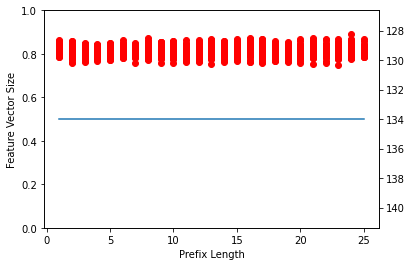

LIME: 0.8146213261648745
xgboost_prefix_agg


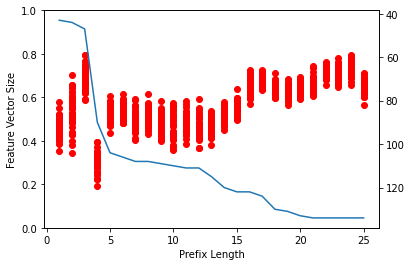

LIME: 0.5675298744489482
xgboost_prefix_index


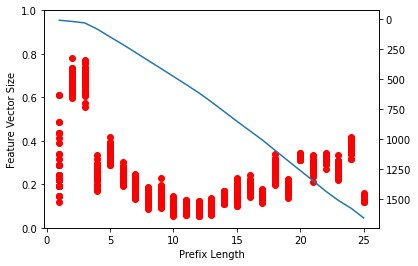

LIME: 0.24222560122517695


In [8]:
datasets = ["bpic2012"]
#datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}
data_names = {"production":"Production", "sepsis_cases":"Sepsis Cases", "bpic2012":"BPIC2012"}
method_names = {"xgboost_single_agg": "Single Bucket with Aggregate Encoding", 
               "xgboost_prefix_agg": "Prefix-Length Buckets with Aggregate Encoding", 
               "xgboost_prefix_index": "Prefix-Length Buckets with Index-Based Encoding"}

all_pref_lens = []
all_proba = []
all_feat_vec = []
all_explainers = []
all_datasets = []
all_methods = []
all_stability = []
hue_lens = []

data_dict = {"Prefix lengths": all_pref_lens, "Prediction Probability": all_proba, "Explainer": all_explainers,
       "Stability": all_stability, "Dataset": all_datasets, "Method": all_methods, "Hue": hue_lens, 'Feature Vector Sizes': all_feat_vec}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/samples/" %(data, method))
        
        nr_events = []
        proba = []
        lime_stability = []
        tree_shap_stability = []
        feat_vec = []
        
        for each in os.listdir(folder_loc):
            file  = os.path.join(folder_loc, each)
            with open (file, 'rb') as f:
                results = pickle.load(f)
                
            if results != []:
                results = pd.DataFrame.from_records(results)
            
                bucket_events = pd.Series(results['nr_events'])
                bucket_proba = pd.Series(results['proba'])
                bucket_lime_stability = pd.Series(results['lime_stability'])
                #bucket_tree_shap_stability = pd.Series(results['tree_shap_stability'])

                nr_events.extend(bucket_events)
                proba.extend(bucket_proba)
                lime_stability.extend(bucket_lime_stability)
                #tree_shap_stability.extend(bucket_tree_shap_stability)
                
        for length in nr_events:
            feat_vec.append(size_dict[method][str(length)])
        
        plot_lens = list(set(nr_events))
        plot_vecs = [size_dict[method][str(i)] for i in plot_lens]
        
        fig, ax = plt.subplots()
        ax.plot(nr_events, lime_stability, 'ro', label = "LIME")
        ax2 = ax.twinx()
        ax2.plot(plot_lens, plot_vecs, label = "Feature Vector")
        ax.set_xlabel("Prefix Length")
        ax.set_ylabel("Stability")
        ax.set_ylabel("Feature Vector Size")
        #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
        #plt.yticks(np.arange(0,1, 0.1))
        ax.set_ylim(0, 1)
        ax2.invert_yaxis()
        #plt.title("Prefix length and stability by index \nBPIC 2012 Prefix-Length Bucket with Index-Based Encoding")
        plt.show()
        
        
        #for i in range(2):
        all_pref_lens.extend(nr_events)
        all_proba.extend(proba)
        all_datasets.extend([data]*len(nr_events))
        all_methods.extend([method]*len(nr_events))
        all_feat_vec.extend(feat_vec)

        all_explainers.extend(["LIME"]*len(nr_events))
#        all_explainers.extend(["SHAP"]*len(nr_events))
        
        all_stability.extend(lime_stability)
 #       all_stability.extend(tree_shap_stability)
            
        avg_lime_stability = np.mean(lime_stability)
  #      avg_shap_stability = np.mean(tree_shap_stability)

        print("LIME:", avg_lime_stability)
   #     print("SHAP:", avg_shap_stability)
            
max_len = max(all_pref_lens)
bins = np.arange(-5, max_len+10, 5)
labels = []
for i in range(len(bins)-1):
    start = str(int(bins[i]+1))
    end = str(int(bins[i+1]))
    label = start+"-"+end+" prefixes"
    labels.append(label)

for length in all_pref_lens:
    cur_bin = 0
    while length > bins[cur_bin+1]:
        cur_bin += 1
    hue_lens.append(labels[cur_bin])

    
# def two_axes(x, y1, y2):
#     ax = plt.gca()
#     ax2 = ax.twinx()
#     ax2.set_y_label('Feature Vector Size')
#     ax.set_y_label('Stability')
    
#     ax.plot(x, y1, 'bo')
#     ax2.plot(x, y2, color = 'red')

    
# comb_data = pd.DataFrame(data_dict)
# comb_data = comb_data.sort_values('Method', ascending = False)
# comb_data = comb_data.sort_values('Prefix lengths')
# grid = sns.FacetGrid(comb_data, col = 'Method', row = 'Explainer', legend_out = True, height = 4, aspect = 1, palette = 'colorblind', ylim = (0, 1.1))
# grid.map(sns.scatterplot, "Prefix lengths", "Stability")
# grid.map(plt.plot, "Prefix lengths", 'Feature Vector Sizes')
# for axes, (_, subdata) in zip(grid.axes, comb_data.groupby(['Method', 'Prefix lengths'])):
#     ax2=ax.twinx()
#     subdata.plot(x='Prefix lengths',y='Feature Vector Sizes', ax=ax2,legend=False,color='r')
# grid.set_axis_labels("Prefix lengths", "Stability")
# grid.add_legend()
# plt.show()

bpic2012
xgboost_single_agg
LIME: 0.8146213261648745
xgboost_prefix_agg
LIME: 0.5675298744489482
xgboost_prefix_index
LIME: 0.24222560122517695


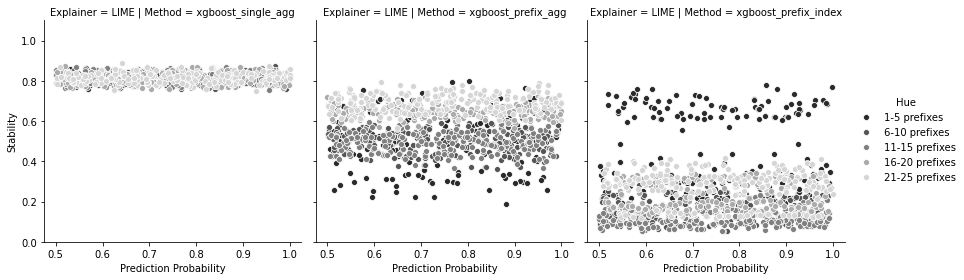

In [22]:
datasets = ["bpic2012"]
#datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}
data_names = {"production":"Production", "sepsis_cases":"Sepsis Cases", "bpic2012":"BPIC2012"}
method_names = {"xgboost_single_agg": "Single Bucket with Aggregate Encoding", 
               "xgboost_prefix_agg": "Prefix-Length Buckets with Aggregate Encoding", 
               "xgboost_prefix_index": "Prefix-Length Buckets with Index-Based Encoding"}

all_pref_lens = []
all_proba = []
all_explainers = []
all_datasets = []
all_methods = []
all_stability = []
hue_lens = []

data_dict = {"Prefix lengths": all_pref_lens, "Prediction Probability": all_proba, "Explainer": all_explainers,
       "Stability": all_stability, "Dataset": all_datasets, "Method": all_methods, "Hue": hue_lens}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/samples/" %(data, method))
        
        nr_events = []
        proba = []
        lime_stability = []
        tree_shap_stability = []
        
        for each in os.listdir(folder_loc):
            file  = os.path.join(folder_loc, each)
            with open (file, 'rb') as f:
                results = pickle.load(f)
            
            if results != []:
                results = pd.DataFrame.from_records(results)
            
                bucket_events = pd.Series(results['nr_events'])
                bucket_proba = pd.Series(results['proba'])
                bucket_lime_stability = pd.Series(results['lime_stability'])
                #bucket_tree_shap_stability = pd.Series(results['tree_shap_stability'])

                nr_events.extend(bucket_events)
                proba.extend(bucket_proba)
                lime_stability.extend(bucket_lime_stability)
                #tree_shap_stability.extend(bucket_tree_shap_stability)
                
        #for i in range(2):
        all_pref_lens.extend(nr_events)
        all_proba.extend(proba)
        all_datasets.extend([data]*len(nr_events))
        all_methods.extend([method]*len(nr_events))

        all_explainers.extend(["LIME"]*len(nr_events))
#        all_explainers.extend(["SHAP"]*len(nr_events))
        
        all_stability.extend(lime_stability)
 #       all_stability.extend(tree_shap_stability)
            
        avg_lime_stability = np.mean(lime_stability)
  #      avg_shap_stability = np.mean(tree_shap_stability)

        print("LIME:", avg_lime_stability)
   #     print("SHAP:", avg_shap_stability)
            
max_len = max(all_pref_lens)
bins = np.arange(-5, max_len+10, 5)
labels = []
for i in range(len(bins)-1):
    start = str(int(bins[i]+1))
    end = str(int(bins[i+1]))
    label = start+"-"+end+" prefixes"
    labels.append(label)

for length in all_pref_lens:
    cur_bin = 0
    while length > bins[cur_bin+1]:
        cur_bin += 1
    hue_lens.append(labels[cur_bin])
                
comb_data = pd.DataFrame(data_dict)
#comb_data = comb_data.sort_values('Method', ascending = False)
comb_data = comb_data.sort_values(['Prefix lengths', 'Explainer'])
grid = sns.FacetGrid(comb_data, col = 'Method', row = 'Explainer', hue = 'Hue', 
                     legend_out = True, height = 4, aspect = 1, palette = 'gray', ylim = (0, 1.1))
grid.map(sns.scatterplot, "Prediction Probability", "Stability")
grid.set_axis_labels("Prediction Probability", "Stability")
grid.add_legend()
plt.show()

bpic2012
xgboost_single_agg
LIME: 0.8546317075472512
xgboost_prefix_agg
LIME: 0.6666338260750934
xgboost_prefix_index
LIME: 0.29974142977902074


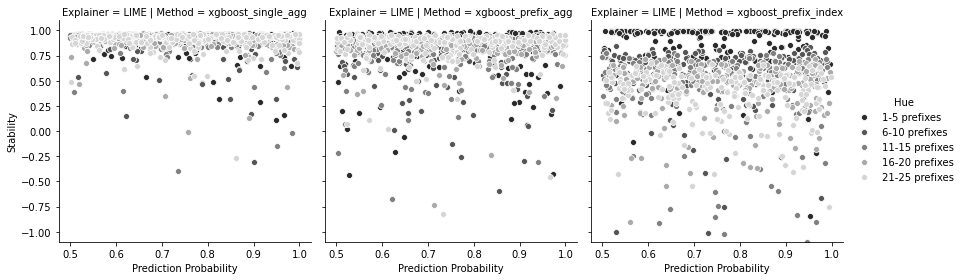

In [23]:
datasets = ["bpic2012"]
#datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}
data_names = {"production":"Production", "sepsis_cases":"Sepsis Cases", "bpic2012":"BPIC2012"}
method_names = {"xgboost_single_agg": "Single Bucket with Aggregate Encoding", 
               "xgboost_prefix_agg": "Prefix-Length Buckets with Aggregate Encoding", 
               "xgboost_prefix_index": "Prefix-Length Buckets with Index-Based Encoding"}

all_pref_lens = []
all_proba = []
all_explainers = []
all_datasets = []
all_methods = []
all_stability = []
hue_lens = []

data_dict = {"Prefix lengths": all_pref_lens, "Prediction Probability": all_proba, "Explainer": all_explainers,
       "Stability": all_stability, "Dataset": all_datasets, "Method": all_methods, "Hue": hue_lens}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/samples/" %(data, method))
        
        nr_events = []
        proba = []
        lime_stability = []
        tree_shap_stability = []
        
        for each in os.listdir(folder_loc):
            file  = os.path.join(folder_loc, each)
            with open (file, 'rb') as f:
                results = pickle.load(f)
            
            if results != []:
                results = pd.DataFrame.from_records(results)
            
                bucket_events = pd.Series(results['nr_events'])
                bucket_proba = pd.Series(results['proba'])
                bucket_lime_stability = pd.Series(results['adjusted_lime_importance_stability'])
                #bucket_tree_shap_stability = pd.Series(results['adjusted_shap_importance_stability'])

                nr_events.extend(bucket_events)
                proba.extend(bucket_proba)
                lime_stability.extend(bucket_lime_stability)
                #tree_shap_stability.extend(bucket_tree_shap_stability)
                
        #for i in range(2):
        all_pref_lens.extend(nr_events)
        all_proba.extend(proba)
        all_datasets.extend([data]*len(nr_events))
        all_methods.extend([method]*len(nr_events))

        all_explainers.extend(["LIME"]*len(nr_events))
        #all_explainers.extend(["SHAP"]*len(nr_events))
        
        all_stability.extend(lime_stability)
        #all_stability.extend(tree_shap_stability)
            
        avg_lime_stability = np.mean(lime_stability)
        #avg_shap_stability = np.mean(tree_shap_stability)

        print("LIME:", avg_lime_stability)
        #print("SHAP:", avg_shap_stability)
            
max_len = max(all_pref_lens)
bins = np.arange(-5, max_len+10, 5)
labels = []
for i in range(len(bins)-1):
    start = str(int(bins[i]+1))
    end = str(int(bins[i+1]))
    label = start+"-"+end+" prefixes"
    labels.append(label)

for length in all_pref_lens:
    cur_bin = 0
    while length > bins[cur_bin+1]:
        cur_bin += 1
    hue_lens.append(labels[cur_bin])
                
comb_data = pd.DataFrame(data_dict)
#comb_data = comb_data.sort_values('Method', ascending = False)
comb_data = comb_data.sort_values(['Prefix lengths', 'Explainer'])
grid = sns.FacetGrid(comb_data, col = 'Method', row = 'Explainer', hue = 'Hue', 
                     legend_out = True, height = 4, aspect = 1, palette = 'gray', ylim = (-1.1, 1.1))
grid.map(sns.scatterplot, "Prediction Probability", "Stability")
grid.set_axis_labels("Prediction Probability", "Stability")
grid.add_legend()
plt.show()

production
xgboost_single_agg
LIME: 0.2604979788542514
SHAP: 0.27469174680679204
xgboost_prefix_agg
LIME: 0.47366466356136006
SHAP: 0.5089115965891036
xgboost_prefix_index
LIME: 0.3585034241195877
SHAP: 0.5103312369683687
sepsis_cases
xgboost_single_agg
LIME: 0.35960311142519635
SHAP: 0.46027759028983267
xgboost_prefix_agg
LIME: 0.3744494652066537
SHAP: 0.4878459323145076
xgboost_prefix_index
LIME: 0.514911224795386
SHAP: 0.5632143593134832
bpic2012
xgboost_single_agg
LIME: 0.37220934358942104
SHAP: 0.41453806470687543
xgboost_prefix_agg
LIME: 0.3785738615379294
SHAP: 0.4164828308584071
xgboost_prefix_index
LIME: 0.316491232210647
SHAP: 0.3977022960252316


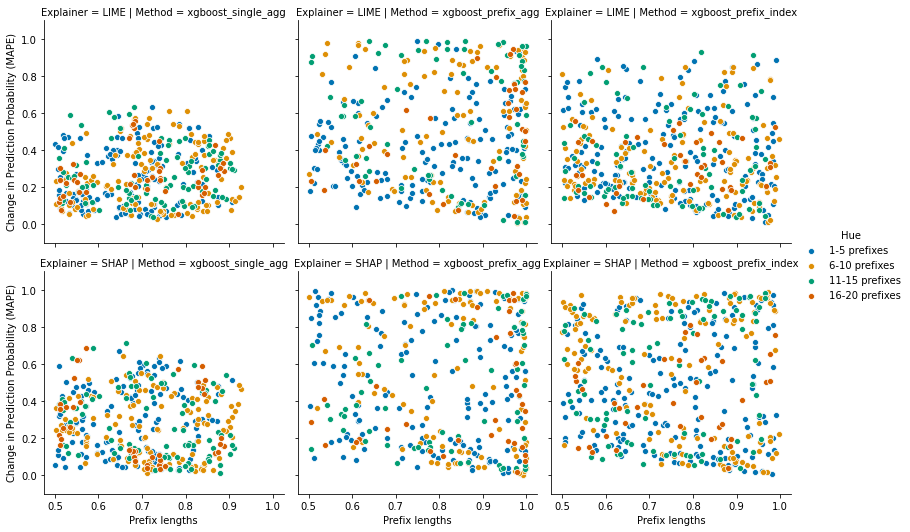

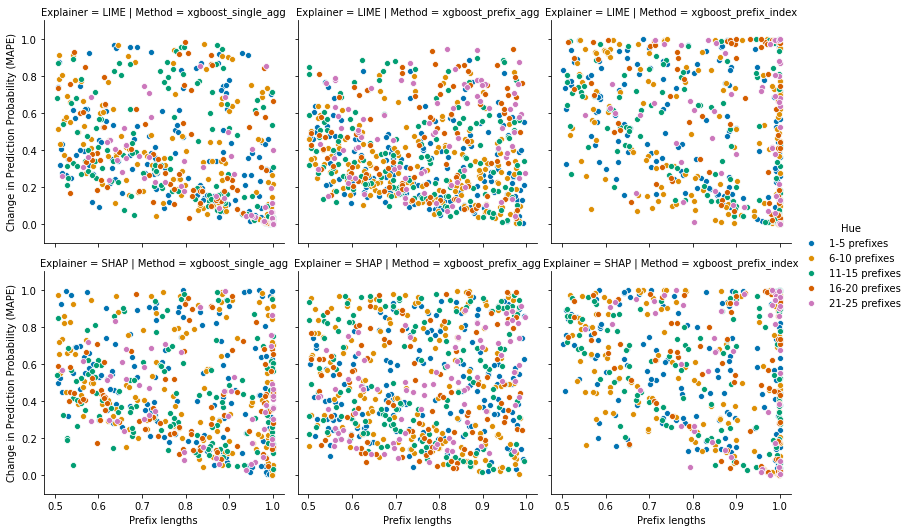

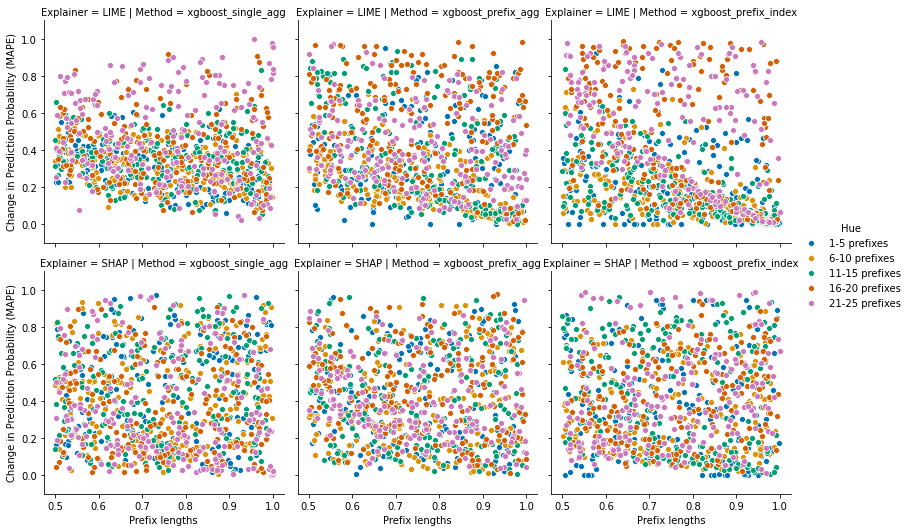

In [11]:
#datasets = ["bpic2012"]
datasets = ["production", "sepsis_cases", "bpic2012"]
#methods = ["xgboost_prefix_index"]
methods = ["xgboost_single_agg", "xgboost_prefix_agg", "xgboost_prefix_index"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}
data_names = {"production":"Production", "sepsis_cases":"Sepsis Cases", "bpic2012":"BPIC2012"}
method_names = {"xgboost_single_agg": "Single Bucket with Aggregate Encoding", 
               "xgboost_prefix_agg": "Prefix-Length Buckets with Aggregate Encoding", 
               "xgboost_prefix_index": "Prefix-Length Buckets with Index-Based Encoding"}

all_pref_lens = []
all_proba = []
all_explainers = []
all_datasets = []
all_methods = []
all_fidelity = []
hue_lens = []

data_dict = {"Prefix lengths": all_pref_lens, "Prediction Probability": all_proba, "Explainer": all_explainers,
       "Fidelity": all_fidelity, "Dataset": all_datasets, "Method": all_methods, "Hue": hue_lens}

for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/samples/" %(data, method))
        
        nr_events = []
        proba = []
        lime_fidelity = []
        tree_shap_fidelity = []
        
        for each in os.listdir(folder_loc):
            file  = os.path.join(folder_loc, each)
            with open (file, 'rb') as f:
                results = pickle.load(f)
            
            if results != []:
                results = pd.DataFrame.from_records(results)
            
                bucket_events = pd.Series(results['nr_events'])
                bucket_proba = pd.Series(results['proba'])
                lime_diffs = pd.Series(results['lime_fid_change'])
                shap_diffs = pd.Series(results['shap_fid_change'])
                
                lime_mape = []
                shap_mape = []
                
                for j in range(len(lime_diffs)):
                    p1 = bucket_proba[j]
                    
                    lime_diff = lime_diffs[j]
                    shap_diff = shap_diffs[j]
                                        
                    lime_rel_changes = []
                    shap_rel_changes = []
                    
                    for each in lime_diff:
                        lime_rel_changes.append(abs(each)/p1)
                        
                    for each in shap_diff:
                        shap_rel_changes.append(abs(each)/p1)
                    
                    lime_mape.append(sum(lime_rel_changes)/len(lime_rel_changes))
                    shap_mape.append(sum(shap_rel_changes)/len(shap_rel_changes))

                nr_events.extend(bucket_events)
                proba.extend(bucket_proba)
                lime_fidelity.extend(lime_mape)
                tree_shap_fidelity.extend(shap_mape)
                
        for i in range(2):
            all_pref_lens.extend(nr_events)
            all_proba.extend(proba)
            all_datasets.extend([data]*len(nr_events))
            all_methods.extend([method]*len(nr_events))

        all_explainers.extend(["LIME"]*len(nr_events))
        all_explainers.extend(["SHAP"]*len(nr_events))

        all_fidelity.extend(lime_fidelity)
        all_fidelity.extend(tree_shap_fidelity)

        avg_lime_fidelity = np.mean(lime_fidelity)
        avg_shap_fidelity = np.mean(tree_shap_fidelity)

        print("LIME:", avg_lime_fidelity)
        print("SHAP:", avg_shap_fidelity)
            
max_len = max(all_pref_lens)
bins = np.arange(-5, max_len+10, 5)
labels = []
for i in range(len(bins)-1):
    start = str(int(bins[i]+1))
    end = str(int(bins[i+1]))
    label = start+"-"+end+" prefixes"
    labels.append(label)

for length in all_pref_lens:
    cur_bin = 0
    while length > bins[cur_bin+1]:
        cur_bin += 1
    hue_lens.append(labels[cur_bin])
                
comb_data = pd.DataFrame(data_dict)
# comb_data = comb_data.sort_values(['Prefix lengths', 'Explainer'])
# #data_fid = data_fid.sort_values('Method', ascending = False)
# grid = sns.FacetGrid(comb_data, col = 'Dataset', row = 'Explainer', hue = 'Hue', 
#                      legend_out = True, height = 5, aspect = 1, palette = 'colorblind', ylim = (-0.1, 1.1))
# grid.map(sns.scatterplot, "Prediction Probability", "Fidelity")
# grid.set_axis_labels("Prefix lengths", "Change in Prediction Probability (MAPE)")
# grid.add_legend()
# plt.show()
for data in datasets:
    data_fid = comb_data[comb_data["Dataset"] == data]
    data_fid = data_fid.sort_values(['Prefix lengths', 'Explainer'])
    #data_fid = data_fid.sort_values('Method', ascending = False)
    grid = sns.FacetGrid(data_fid, col = 'Method', row = 'Explainer', hue = 'Hue', 
                         legend_out = True, height = 3.75, aspect = 1, palette = 'colorblind', ylim = (-0.1, 1.1))
    grid.map(sns.scatterplot, "Prediction Probability", "Fidelity")
    grid.set_axis_labels("Prefix lengths", "Change in Prediction Probability (MAPE)")
    grid.add_legend()
    plt.show()

In [12]:
data_fid

,Prefix lengths,Prediction Probability,Explainer,Fidelity,Dataset,Method,Hue
5850,1,0.540455,LIME,0.392334,bpic2012,xgboost_single_agg,1-5 prefixes
5854,1,0.550972,LIME,0.401933,bpic2012,xgboost_single_agg,1-5 prefixes
5879,1,0.612841,LIME,0.309141,bpic2012,xgboost_single_agg,1-5 prefixes
5902,1,0.647366,LIME,0.305786,bpic2012,xgboost_single_agg,1-5 prefixes
5960,1,0.769564,LIME,0.411083,bpic2012,xgboost_single_agg,1-5 prefixes
...,...,...,...,...,...,...,...
11743,25,0.774923,SHAP,0.163850,bpic2012,xgboost_prefix_index,21-25 prefixes
11744,25,0.860452,SHAP,0.150264,bpic2012,xgboost_prefix_index,21-25 prefixes
11745,25,0.892020,SHAP,0.096002,bpic2012,xgboost_prefix_index,21-25 prefixes
11746,25,0.916731,SHAP,0.075851,bpic2012,xgboost_prefix_index,21-25 prefixes


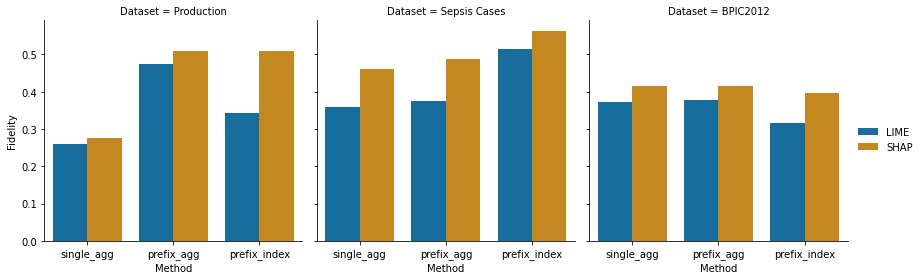

In [13]:
methods = ["single_agg", "prefix_agg", "prefix_index", "single_agg", "prefix_agg", "prefix_index", 
           "single_agg", "prefix_agg", "prefix_index", "single_agg", "prefix_agg", "prefix_index",
           "single_agg", "prefix_agg", "prefix_index", "single_agg", "prefix_agg", "prefix_index"]

fidelity = [0.2604979788542514, 0.47366466356136006, 0.34376828026350076, 0.27469174680679204, 0.5089115965891036, 0.5080608320400524,
            0.35960311142519635, 0.3744494652066537, 0.514911224795386, 0.4602775902898326, 0.4878459323145076, 0.5632143593134832,
            0.372209343589421, 0.3785738615379294, 0.31649123221064696, 0.4145380647068754, 0.4164828308584071, 0.39770229602523155]
explainers = ["LIME", "LIME", "LIME", "SHAP", "SHAP", "SHAP",
             "LIME", "LIME", "LIME", "SHAP", "SHAP", "SHAP",
             "LIME", "LIME", "LIME", "SHAP", "SHAP", "SHAP"]
datasets = ["Production", "Production", "Production", "Production", "Production", "Production",
            "Sepsis Cases", "Sepsis Cases", "Sepsis Cases", "Sepsis Cases", "Sepsis Cases", "Sepsis Cases",
            "BPIC2012", "BPIC2012", "BPIC2012", "BPIC2012", "BPIC2012", "BPIC2012"]

data_dict = {"Dataset": datasets, "Explainer": explainers, "Fidelity": fidelity, "Method": methods}

data = pd.DataFrame(data_dict)

grid = sns.FacetGrid(data,  col = 'Dataset',# hue = 'Explainer', 
                     legend_out = True, height = 4, aspect = 1)#, palette = 'colorblind')
grid.map(sns.barplot, "Method", "Fidelity", hue = data["Explainer"], palette = "colorblind")
grid.set_axis_labels("Method", "Fidelity")
grid.add_legend()
plt.show()

<AxesSubplot:xlabel='Method', ylabel='Fidelity'>

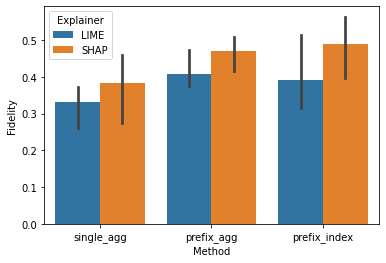

In [14]:
sns.barplot(data["Method"], data["Fidelity"], hue = data['Explainer'])

production
lstm_single_3d
Bucket all
Parameters loaded
defining input layer
adding lstm layers
adding dense layers
putting together layers
choosing optimiser
adding weights to model
compiling model
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



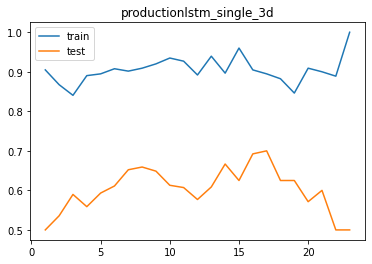

	Training accuracy: 0.897410358565737
		Training accuracy - Positives: 0.9854545454545455
		Training accuracy - Negatives: 0.7907488986784141
	Testing accuracy: 0.5902503293807642
		Testing accuracy - Positives: 0.5344202898550725
		Testing accuracy - Negatives: 0.7391304347826086
sepsis_cases
lstm_single_3d
Bucket all
Parameters loaded
defining input layer
adding lstm layers
adding dense layers
putting together layers
choosing optimiser
adding weights to model
compiling model


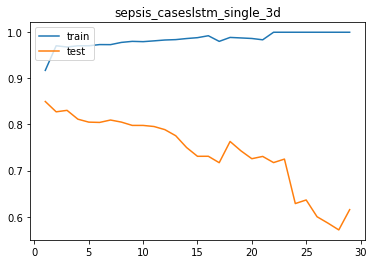

	Training accuracy: 0.9748176450156304
		Training accuracy - Positives: 0.9879227053140096
		Training accuracy - Negatives: 0.9726166328600405
	Testing accuracy: 0.788406390823433
		Testing accuracy - Positives: 0.09111617312072894
		Testing accuracy - Negatives: 0.8573036236776953
bpic2012
lstm_single_3d
Bucket all
Parameters loaded
defining input layer
adding lstm layers
adding dense layers
putting together layers
choosing optimiser
adding weights to model
compiling model


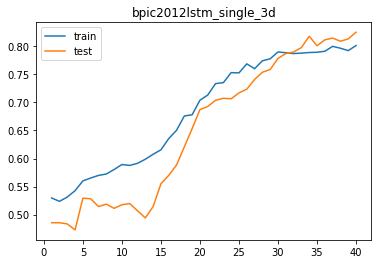

	Training accuracy: 0.6585667038914182
		Training accuracy - Positives: 0.6922325740980232
		Training accuracy - Negatives: 0.6354749361863901
	Testing accuracy: 0.6225152593269576
		Testing accuracy - Positives: 0.6415035074861271
		Testing accuracy - Negatives: 0.5910706545296922


In [15]:
datasets = ["production", "sepsis_cases", "bpic2012"]
methods = ["lstm_single_3d"]
dataset_names = {"production":"production", "sepsis_cases":"sepsis_cases_1", "bpic2012":"bpic2012_accepted"}


for data in datasets:
    print(data)
            
    dataset_manager = DatasetManager(dataset_names[data])

    
    for method in methods:
        print(method)
        folder_loc = os.path.join(PATH, "%s/%s/" %(data, method))
        
        if "single" in method:
            num_buckets = 1
        else:
            num_buckets = len([name for name in os.listdir(os.path.join(folder_loc,'models/'))])
            
        train_lengths = []
        train_predictions = []
        train_y_all = []
        
        test_lengths = []
        test_predictions = []
        test_y_all = []
            
        for bucket in range(num_buckets):
            if "lstm" in method:
                bucketID = "all"
            else:
                bucketID = bucket+1
            print ('Bucket', bucketID)
            
            X_train_path = os.path.join(folder_loc, "train_data/bucket_%s_prefixes.pickle" % (bucketID))
            with open (X_train_path, 'rb') as f:
                dt_train_bucket = pickle.load(f)

            X_test_path = os.path.join(folder_loc, "test_data/bucket_%s_prefixes.pickle" % (bucketID))
            with open (X_test_path, 'rb') as f:
                dt_test_bucket = pickle.load(f)
            
            for each in dt_train_bucket:
                prefs = [np.any(row) for row in each]
                pref_length = prefs.count(True)
                train_lengths.append(pref_length)
                
            for each in dt_test_bucket:
                prefs = [np.any(row) for row in each]
                pref_length = prefs.count(True)
                test_lengths.append(pref_length)

            y_train_path = os.path.join(folder_loc, "train_data/bucket_%s_labels.pickle" % (bucketID))
            with open (y_train_path, 'rb') as f:
                train_y = pickle.load(f)

            y_test_path = os.path.join(folder_loc, "test_data/bucket_%s_labels.pickle" % (bucketID))
            with open (y_test_path, 'rb') as f:
                test_y = pickle.load(f)

            y_train = [int(np.where(i==1)[0]) for i in train_y]
            y_test = test_y
            
            train_y_all.extend(y_train)
            test_y_all.extend(y_test)

            params_path = os.path.join(folder_loc, "cls/params.pickle")
            with open (params_path, 'rb') as f:
                args = pickle.load(f)
                    
            max_len = args['max_len']
            data_dim = args['data_dim']
            print("Parameters loaded")

            #create model
            print("defining input layer")
            main_input = Input(shape=(max_len, data_dim), name='main_input')

            print("adding lstm layers")
            if args["lstm_layers"]["layers"] == "one":
                l2_3 = LSTM(args['lstm1_nodes'], input_shape=(max_len, data_dim), implementation=2, 
                            kernel_initializer='glorot_uniform', return_sequences=False, 
                            recurrent_dropout=args['lstm1_dropouts'], stateful = False)(main_input)
                b2_3 = BatchNormalization()(l2_3)

            if args["lstm_layers"]["layers"] == "two":
                l1 = LSTM(args['lstm1_nodes'], input_shape=(max_len, data_dim), implementation=2, 
                        kernel_initializer='glorot_uniform', return_sequences=True, 
                        recurrent_dropout=args['lstm1_dropouts'], stateful = False)(main_input)
                b1 = BatchNormalization()(l1)
                l2_3 = LSTM(args["lstm_layers"]["lstm2_nodes"], activation="sigmoid", 
                            implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, 
                            recurrent_dropout=args["lstm_layers"]["lstm2_dropouts"], stateful = False)(b1)
                b2_3 = BatchNormalization()(l2_3)

            if args["lstm_layers"]["layers"] == "three":
                l1 = LSTM(args['lstm1_nodes'], input_shape=(max_len, data_dim),implementation=2, 
                        kernel_initializer='glorot_uniform', return_sequences=True, 
                        recurrent_dropout=args['lstm1_dropouts'], stateful = False)(main_input)
                b1 = BatchNormalization()(l1)
                l2 = LSTM(args["lstm_layers"]["lstm2_nodes"], activation="sigmoid", 
                            implementation=2, kernel_initializer='glorot_uniform', return_sequences=True, 
                            recurrent_dropout=args["lstm_layers"]["lstm2_dropouts"], stateful = False)(b1)
                b2 = BatchNormalization()(l2)
                l2_3 = LSTM(args["lstm_layers"]["lstm3_nodes"], activation="sigmoid", 
                            implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, 
                            recurrent_dropout=args["lstm_layers"]["lstm3_dropouts"], stateful = False)(b2)
                b2_3 = BatchNormalization()(l2_3)

            print("adding dense layers")
            if args['dense_layers']['layers'] == "two":
                d1 = Dense(args['dense_layers']['dense2_nodes'], activation = "relu")(b2_3)
                outcome_output = Dense(2, activation='sigmoid', kernel_initializer='glorot_uniform', name='outcome_output')(d1)

            else:
                outcome_output = Dense(2, activation='sigmoid', kernel_initializer='glorot_uniform', name='outcome_output')(b2_3)

            print("putting together layers")
            cls = Model(inputs=[main_input], outputs=[outcome_output])

            print("choosing optimiser")
            if args['optimizer'] == "adam":
                opt = Nadam(lr=args['learning_rate'], beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)
            elif args['optimizer'] == "rmsprop":
                opt = RMSprop(lr=args['learning_rate'], rho=0.9, epsilon=1e-08, decay=0.0)

            print("adding weights to model")
            #print(os.getcwd())
            #print(folder_loc)
            checkpoint_path = os.path.join(folder_loc, "cls/cls.h5")
            #print(folder_loc)
            #print(checkpoint_path)
            #checkpointPath = "C:\\Users\\mythr\\Documents\\GitHub\\Stability-Experiments\\benchmark_interpretability\\PPM_Stability\\production\\lstm_single_3d\\cls\\checkpoint.cpt"

            #with open (checkpoint_path, 'r') as f:
            #    print(f)
            #    cpt = cls.load_weights(f)
            weights = cls.load_weights(checkpoint_path)
            #print(weights.assert_consumed())

            print("compiling model")
            cls.compile(loss='binary_crossentropy', optimizer=opt)

            preds = cls.predict(dt_train_bucket)
            train_preds = [np.argmax(i, axis = -1) for i in preds]
            train_predictions.extend(train_preds)

            preds = cls.predict(dt_test_bucket)
            test_preds = [np.argmax(i, axis = -1) for i in preds]
            test_predictions.extend(test_preds)
            
            
            
        lens = list(set(train_lengths))
        train_accs = []
        test_accs = []
        for i in lens:
            idxs = [n for n in range(len(train_lengths)) if train_lengths[n] == i]
            preds = [train_predictions[n] for n in idxs]
            actual = [train_y_all[n] for n in idxs]
            accuracy = accuracy_score(actual, preds)
            train_accs.append(accuracy)
            
            idxs = [n for n in range(len(test_lengths)) if test_lengths[n] == i]
            preds = [test_predictions[n] for n in idxs]
            actual = [test_y_all[n] for n in idxs]
            accuracy = accuracy_score(actual, preds)
            test_accs.append(accuracy)


        plt.plot(lens, train_accs, label = 'train')
        plt.plot(lens, test_accs, label = 'test')
        plt.legend(loc = "upper left")
        plt.title(data+method)
        plt.show()
        
        train_acc = accuracy_score(train_y_all, train_predictions)
        print("\tTraining accuracy:", train_acc)
        
        train_pos_idx = [i for i in range(len(train_predictions)) if train_predictions[i] == 1]
        actual = [train_y_all[i] for i in train_pos_idx]
        preds = [train_predictions[i] for i in train_pos_idx]
        train_pos_acc = accuracy_score(actual, preds)
        print("\t\tTraining accuracy - Positives:", train_pos_acc)
        
        train_neg_idx = [i for i in range(len(train_predictions)) if train_predictions[i] == 0]
        actual = [train_y_all[i] for i in train_neg_idx]
        preds = [train_predictions[i] for i in train_neg_idx]
        train_neg_acc = accuracy_score(actual, preds)
        print("\t\tTraining accuracy - Negatives:", train_neg_acc)
        
        test_acc = accuracy_score(test_y_all, test_predictions)
        print("\tTesting accuracy:", test_acc)
        
        test_pos_idx = [i for i in range(len(test_predictions)) if test_predictions[i] == 1]
        actual = [test_y_all[i] for i in test_pos_idx]
        preds = [test_predictions[i] for i in test_pos_idx]
        test_pos_acc = accuracy_score(actual, preds)
        print("\t\tTesting accuracy - Positives:", test_pos_acc)
        
        test_neg_idx = [i for i in range(len(test_predictions)) if test_predictions[i] == 0]
        actual = [test_y_all[i] for i in test_neg_idx]
        preds = [test_predictions[i] for i in test_neg_idx]
        test_neg_acc = accuracy_score(actual, preds)
        print("\t\tTesting accuracy - Negatives:", test_neg_acc)
            
        #break
                